# 👋 Welcome to the **CRAFT** Pytorch tutorial


In this tutorial, we will take a model, several images and run CRAFT to extract concepts and then display them using Concept Attribution Maps.

# 1 - Loading and preparing the model

🛠 CRAFT requires splitting the model in two parts. So, we will prepare two functions $(g, h)$ such that $f(x) = (g \cdot h)(x)$. To put it simply, $g$ is the function that maps our input to the latent space (the penultimate layer of our model), and $h$ is the function that maps this penultimate layer to the output. It is important to note that if the model contains a global average pooling layer, it is strongly recommended to provide CRAFT with the layer before the global average pooling.

⚠️ Please keep in mind that the activations must be positives (after relu or any positive activation function)

In [17]:
!pip install tensorflow-macos
!pip install tensorflow-metal

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [18]:
!pip install -q timm
!pip install facenet-pytorch

!curl -O https://repo.anaconda.com/miniconda/Miniconda3-latest-MacOSX-arm64.sh
!sh Miniconda3-latest-MacOSX-arm64.sh -b -p $HOME/miniconda
!source $HOME/miniconda/bin/activate
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

!pip install Craft-xai

Defaulting to user installation because normal site-packages is not writeable
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  105M  100  105M    0     0  10.4M      0  0:00:10  0:00:10 --:--:-- 10.6M
ERROR: File or directory already exists: '/Users/hetavpatel/miniconda'
If you want to update an existing installation, use the -u option.
zsh:source:1: no such file or directory: /Users/hetavpatel/miniconda/bin/activate
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu
Defaulting to user installation because normal site-packages is not writeable


# 2 - Prepare the data and the model for CRAFT.


In [53]:
import torch
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from PIL import Image
import numpy as np
import shutil
import pandas as pd
import os

class DatasetPreparation:
    def __init__(self, base_dir, n_samples, seed=42):
        self.base_dir = base_dir
        self.n_samples = n_samples
        np.random.seed(seed)
    
    def load_and_sample_images(self):
        """
        Load and randomly sample images while preserving metadata from filenames
        """
        all_files = [f for f in os.listdir(self.base_dir) if f.endswith('.jpg')]
        # Randomly sample n_samples files
        selected_files = np.random.choice(all_files, size=self.n_samples, replace=False)
        # Create metadata dictionary
        metadata = []
        images = []
        for filename in selected_files:
            # Parse filename
            age, gender, race, datetime = filename.split('_')
            metadata.append({
                'filename': filename,
                'age': int(age),
                'gender': int(gender),
                'race': int(race),
                'datetime': datetime.split('.')[0]
            })
            os.makedirs('facialdataset/content/inputs/0', exist_ok=True)
            os.makedirs('facialdataset/content/inputs/1', exist_ok=True)
            os.makedirs('facialdataset/content/inputs/2', exist_ok=True)
            os.makedirs('facialdataset/content/inputs/3', exist_ok=True)
            os.makedirs('facialdataset/content/inputs/4', exist_ok=True)
            src_path = os.path.join(self.base_dir, filename)
            dst_path = os.path.join('facialdataset/content/inputs', race, filename)
            shutil.copy(src_path, dst_path)
            # Load image
            img = Image.open(dst_path).convert('RGB')
            img = img.resize((160, 160))
            images.append(np.array(img))
        return np.array(images), pd.DataFrame(metadata)
    def get_balanced_sample(self):
        """
        Get samples while maintaining balance across gender and race
        """
        images, metadata = self.load_and_sample_images()
        # Convert to torch tensor and normalize
        images = torch.tensor(images).permute(0, 3, 1, 2).float() / 255.0
        return images, metadata
dataset_prep = DatasetPreparation(base_dir='/Users/hetavpatel/Desktop/Data Science/Grad DS Work/DSCI 789 Explainable AI/CRAFT/Craft-main/facialdataset/part1', n_samples=2500)

images, metadata = dataset_prep.get_balanced_sample() 

**Split the model in 2 parts, g and h.**

In [54]:
class FaceNetEncoder(torch.nn.Module):
    def __init__(self, facenet_model, split_layer='Mixed_7a'):
        super().__init__()
        # Get all layers up to Mixed_7a (pre-bottleneck)
        self.features = torch.nn.ModuleList()
        for layer in facenet_model.children():
            if isinstance(layer, InceptionResnetV1):
                for block in layer.children():
                    self.features.append(block)
                    if block._get_name() == split_layer:
                        break

    def forward(self, x):
        # Ensure positive activations with ReLU
        for layer in self.features:
            x = layer(x)
        return torch.nn.functional.relu(x)

class FaceNetDecoder(torch.nn.Module):
    def __init__(self, facenet_model, split_layer='Mixed_7a'):
        super().__init__()
        # Get remaining layers after Mixed_7a
        self.classifier = torch.nn.ModuleList()
        found_split = False
        for layer in facenet_model.children():
            if isinstance(layer, InceptionResnetV1):
                for block in layer.children():
                    if found_split:
                        self.classifier.append(block)
                    if block._get_name() == split_layer:
                        found_split = True

    def forward(self, x):
        for layer in self.classifier:
            x = layer(x)
        return x

In [55]:
import torch
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from PIL import Image
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = InceptionResnetV1(pretrained= 'vggface2').eval().to(device)

transformImage = transforms.Compose([
    transforms.Resize(size= (160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.5, 0.5, 0.5], std= [0.5, 0.5, 0.5])
])

# # cut the model in two
# g = nn.Sequential(*(list(model.children())[:4])) # input to penultimate layer
# h = lambda x: model.logits(x)  # Penultimate layer to logits



In [56]:
# import numpy as np
# import cv2
# import torch
# import torch.nn as nn

# from torchvision import transforms
# import timm
# from timm.data import resolve_data_config
# from timm.data.transforms_factory import create_transform

# device = 'cuda'

# # loading any timm model
# model = timm.create_model('nf_resnet50.ra2_in1k', pretrained=True)
# model = model.eval().to(device)

# # processing
# config = resolve_data_config({}, model=model)
# transform = create_transform(**config)
# to_pil = transforms.ToPILImage()

# # cut the model in two
# g = nn.Sequential(*(list(model.children())[:4])) # input to penultimate layer
# h = lambda x: model.head.fc(torch.mean(x, (2, 3))) # penultimate layer to logits

In [57]:
# rabbit_class = 330 # imagenet class for rabbit

# # loading some images of rabbits !
# images = np.load('assets/rabbit.npz')['arr_0'].astype(np.uint8)
# images_preprocessed = torch.stack([transform(to_pil(img)) for img in images], 0)

# images_preprocessed.shape

In [58]:
# from tqdm import tqdm
# import os

# # Directory containing part1 images from the facial dataset
# image_dir = '/Users/hetavpatel/Desktop/Data Science/Grad DS Work/DSCI 789 Explainable AI/CRAFT/Craft-main/facialdataset/part1'
# image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('jpg', 'jpeg', 'png'))]

# # Initialize lists to store features and logits
# features_list = []
# logits_list = []

# preprocessed_images = []

# for path in tqdm(image_paths[:10138]):
#     try: 
#         image = Image.open(path).convert('RGB')
#         image_preprocessed = transformImage(image).unsqueeze(0).to(device)
#         preprocessed_images.append(image_preprocessed)
#     except Exception as e:
#         print(f"Error processing images {path}: {e}")

# # # loading some images of rabbits !
# # images = np.load('assets/rabbit.npz')['arr_0'].astype(np.uint8)
# # images_preprocessed = torch.stack([transform(to_pil(img)) for img in images], 0)

# # images_preprocessed.shape
# preprocessed_images = torch.stack([transformImage(to_pil(img)) for img in images], 0)
# print(preprocessed_images.shape)
        

In [59]:
from torchvision.transforms.functional import to_pil_image 
from torchvision.transforms.functional import to_tensor
from torch.utils.data import DataLoader
from torchvision import datasets

workers = 0 
# if os.name == 'nt' else 4

def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('facialdataset/content/inputs')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [60]:
preprocessed_images = []

for img, _ in loader:
    img = transformImage(img)
    preprocessed_images.append(img)

In [61]:
preprocessed_images = torch.stack([to_tensor(to_pil_image(img)) for img in preprocessed_images], 0)
print(preprocessed_images.shape)

torch.Size([3798, 3, 160, 160])


# 3 - Create a CRAFT instance and fit the data to the model

The API of CRAFT is really simple. We have 2 hyperparameters to define. First, the number of concepts ($r$ in the original paper), 10 is enough when we study the penultimate layer for a class of ImageNet. We provide tips and metrics to choose this hyperparameter below.

The second hyperparameter is the `patch_size`, or the size of the patches used for the concept extraction. For image of $224$, we encourage you to stay between $64$ and $128$ (half of the image).

Let's start by instantiating CRAFT

In [62]:
import tensorflow as tf
from craft.craft_torch import Craft, torch_to_numpy

g = FaceNetEncoder(model)
h = FaceNetDecoder(model)

craft = Craft(input_to_latent = g,
              latent_to_logit = h,
              number_of_concepts = 10,
              patch_size = 64,
              batch_size = 64,
              device = device)

# now we can start fit the concept
# CRAFT will (1) create the patches, (2) find the concept
# and (3) return the crops (crops), the embedding of the crops (crops_u), and the concept bank (w)
crops, crops_u, w = craft.fit(preprocessed_images)
crops = np.moveaxis(torch_to_numpy(crops), 1, -1)

crops.shape, crops_u.shape, w.shape

/Users/hetavpatel/Desktop/Data Science/Grad DS Work/DSCI 789 Explainable AI/CRAFT/Craft-main/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])


((15192, 64, 64, 3), (15192, 10), (10, 3))

# 3- Estimating the concept importance

The second crucial step before starting our investigation is to understand which concepts matter. To do so, we use Sobol indices and we compute them using a really simple api!

In [ ]:
importances = craft.estimate_importance(preprocessed_images, class_id= 2) # 330 is the rabbit class id in imagenet
images_u = craft.transform(preprocessed_images)

images_u.shape

/Users/hetavpatel/Desktop/Data Science/Grad DS Work/DSCI 789 Explainable AI/CRAFT/Craft-main/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])


# 4 - Results !

Concept 0  has an importance value of  0.27517086
Concept 3  has an importance value of  0.116319165
Concept 2  has an importance value of  0.006087892
Concept 4  has an importance value of  0.0045609013
Concept 5  has an importance value of  0.0016981056


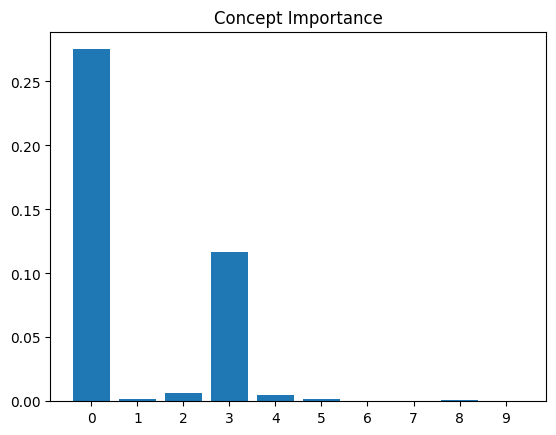

In [ ]:
# We are done, let's inspect the results !
# first, lets see which concepts matter
import matplotlib.pyplot as plt

plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)))
plt.title("Concept Importance")

most_important_concepts = np.argsort(importances)[::-1][:5]

for c_id in most_important_concepts:
  print("Concept", c_id, " has an importance value of ", importances[c_id])

Concept 0  has an importance value of  0.27517086


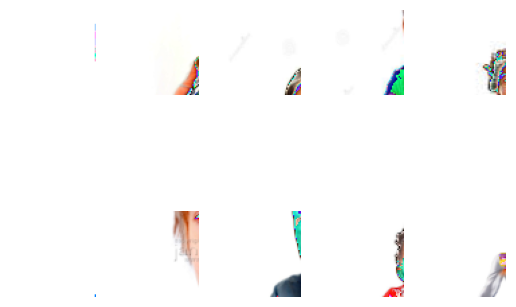




Concept 3  has an importance value of  0.116319165


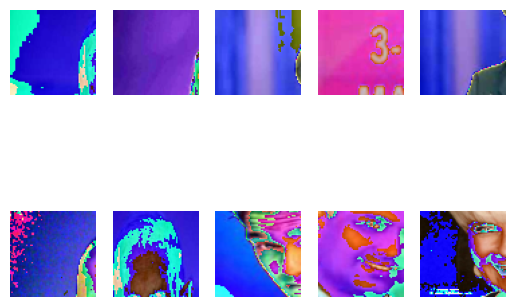




Concept 2  has an importance value of  0.006087892


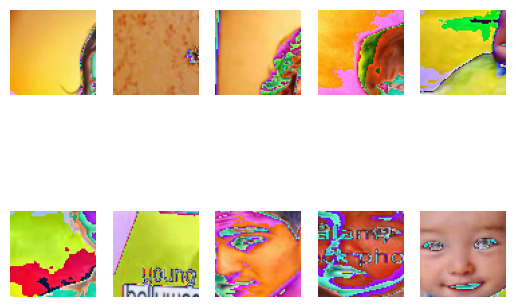




Concept 4  has an importance value of  0.0045609013


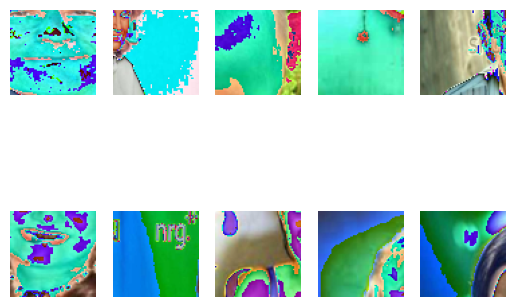




Concept 5  has an importance value of  0.0016981056


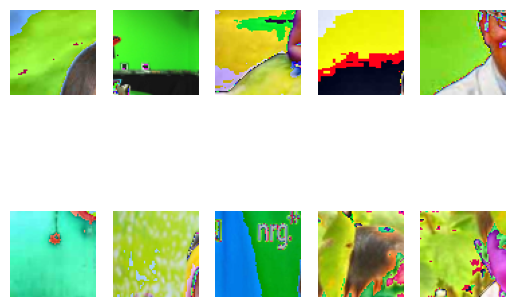

In [ ]:
# Ok nice, let inspect those concepts by showing the 10 best crops for
# each concepts
from math import ceil
nb_crops = 10

def show(img, **kwargs):
  img = np.array(img)
  if img.shape[0] == 3:
    img = img.transpose(1, 2, 0)

  img -= img.min();img /= img.max()
  plt.imshow(img, **kwargs); plt.axis('off')

for c_id in most_important_concepts:

  best_crops_ids = np.argsort(crops_u[:, c_id])[::-1][:nb_crops]
  best_crops = crops[best_crops_ids]

  print("Concept", c_id, " has an importance value of ", importances[c_id])
  for i in range(nb_crops):
    plt.subplot(ceil(nb_crops/5), 5, i+1)
    show(best_crops[i])
  plt.show()
  print('\n\n')

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys

def get_alpha_cmap(cmap):
  if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)
  else:
    c = np.array((cmap[0]/255.0, cmap[1]/255.0, cmap[2]/255.0))

    cmax = colorsys.rgb_to_hls(*c)
    cmax = np.array(cmax)
    cmax[-1] = 1.0

    cmax = np.clip(np.array(colorsys.hls_to_rgb(*cmax)), 0, 1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c,cmax])

  alpha_cmap = cmap(np.arange(256))
  alpha_cmap[:,-1] = np.linspace(0, 0.85, 256)
  alpha_cmap = ListedColormap(alpha_cmap)

  return alpha_cmap

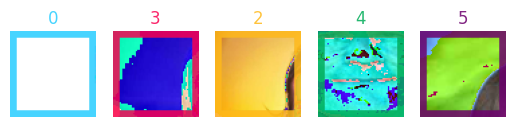

In [ ]:
cmaps = [
  get_alpha_cmap((54, 197, 240)),
  get_alpha_cmap((210, 40, 95)),
  get_alpha_cmap((236, 178, 46)),
  get_alpha_cmap((15, 157, 88)),
  get_alpha_cmap((84, 25, 85))
]

def plot_legend():
  for i, c_id in enumerate(most_important_concepts):
    cmap = cmaps[i]
    plt.subplot(1, len(most_important_concepts), i+1)

    best_crops_id = np.argsort(crops_u[:, c_id])[::-1][0]
    best_crop = crops[best_crops_id]

    p = 5
    mask = np.zeros(best_crop.shape[:-1])
    mask[:p, :] = 1.0
    mask[:, :p] = 1.0
    mask[-p:, :] = 1.0
    mask[:, -p:] = 1.0

    show(best_crop)
    show(mask, cmap=cmap)
    plt.title(f"{c_id}", color=cmap(1.0))

  plt.show()

plot_legend()

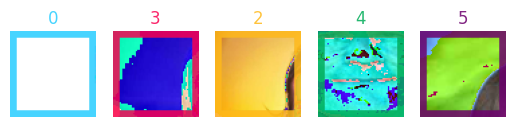

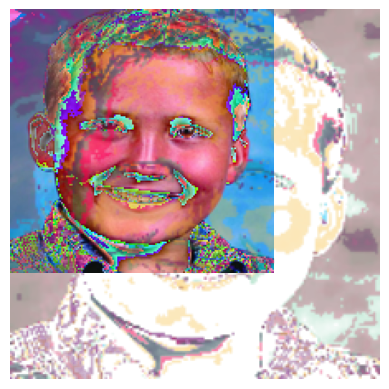

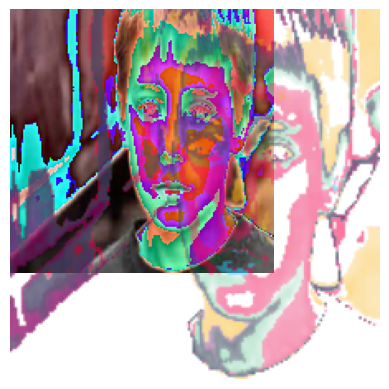

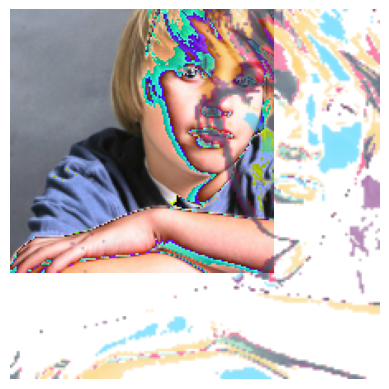

In [ ]:
import cv2

def concept_attribution_maps(id, percentile=90):
  img = preprocessed_images[id]
  u = images_u[id]

  show(img)

  for i, c_id in enumerate(most_important_concepts):

    cmap = cmaps[i]
    heatmap = u[:, :, c_id]

    # only show concept if excess N-th percentile
    sigma = np.percentile(images_u[:,:,:,c_id].flatten(), percentile)
    heatmap = heatmap * np.array(heatmap > sigma, np.float32)

    heatmap = cv2.resize(heatmap[:, :, None], (224, 224))
    show(heatmap, cmap=cmap, alpha=0.7)

  plt.show()

plot_legend()
concept_attribution_maps(0)
plt.show()
concept_attribution_maps(1)
plt.show()
concept_attribution_maps(2)
plt.show()